In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch

## Load the Environment

First, we load the unity-Environment. There are 2 different versions of the Environment: 
There is a Single-Agent Environment and a Multi-Agent Environment. We will use the Multi-Agent Env in this notebook.

In [2]:
#single Agent Version:
#env = UnityEnvironment(file_name='./Reacher_single')

#multiple-Agent Version
env = UnityEnvironment(file_name='./Reacher_multi.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the "brain" from env
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### Train the Agents

This section will train our Agents on the Environment. Since this is quite computational-intensive, this procedure could take some time. 

In [4]:
import torch
from collections import deque
from ddpg_agent import Agent

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output, display

Episode 100	Average Score: 14.26
Episode 200	Average Score: 43.33
Episode 300	Average Score: 73.13
Episode 301	Average Score: 73.43

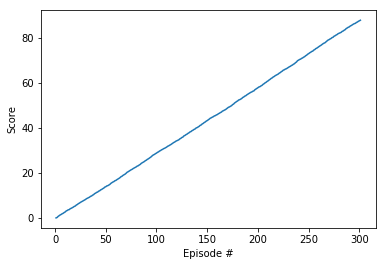

In [6]:
def ddpg(n_episodes=301, max_t=600, save_after_episodes=100):
    avg_score = []
    scores_deque = deque(maxlen=100)
    scores = np.zeros(num_agents)
    updates_per_step = 10
    step_frequence = 20
    
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    
    agents = []
    for i in range(num_agents):
        agent = Agent(state_size=state_size, action_size=action_size, random_seed=2)
        agents.append(agent)
    
    action = [agent.act(states[i]) for i, agent in enumerate(agents)]

    for i_episode in range(1, n_episodes+1):
        states = env_info.vector_observations                  # get the current state (for each agent)
        for agent in agents:
            agent.reset()

        for t in range(max_t):
            actions = [agent.act(states[idx]) for idx, agent in enumerate(agents)]
            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
                        
            for agent, s, a, r, s_, d in zip(agents, states, actions, rewards, next_states, dones):
                agent.memory.add(s, a, r, s_, d)               # update the shared Memory-Buffer
                if ( t % step_frequence == 0):                 # only take a learning step every 20 env-steps
                    agent.step(updates_per_step)
            states  = next_states
            scores += rewards                                  # update the score (for each agent)
            if np.any(dones):                                  # exit loop if episode finished
                break
                
        score = np.mean(scores)        
        avg_score.append(score)
        scores_deque.append(score)    
            
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % save_after_episodes == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

            for idx, agent in enumerate(agents):
                cp_actor = "a_" + str(idx).zfill(2) + ".pth"
                torch.save(agent.actor_local.state_dict(), cp_actor)

                cp_critic = "c_" + str(idx).zfill(2) + ".pth"
                torch.save(agent.critic_local.state_dict(), cp_critic)
            
    return avg_score

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
fig.savefig('result_figure.png')

In [ ]:
env.close()

## Test the Agents
Now, we can test the trained Agents by loading the saved agent models

In [5]:
from collections import deque
from ddpg_agent import Agent

state_size = len(env_info.vector_observations[0])
action_size = brain.vector_action_space_size

testAgents = []

for i in range(num_agents):
    testAgent = Agent(state_size=state_size, action_size=action_size, random_seed=0)
    testAgent.actor_local.load_state_dict(torch.load('models/a_'+str(i).zfill(2)+'.pth', map_location=lambda storage, loc:storage))
    testAgent.critic_local.load_state_dict(torch.load('models/c_'+str(i).zfill(2)+'.pth', map_location=lambda storage, loc:storage))
    testAgents.append(testAgent)

In [6]:
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations
scores_deque = deque(maxlen=100)
scores = np.zeros(num_agents)
max_t = 600

for agent in testAgents:
    agent.reset()

for t in range(max_t):
    actions = [agent.act(states[i],add_noise=False) for i,agent in enumerate(testAgents)]
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += rewards
    states  = next_states
    
    #print("Score: {}".format(np.mean(scores)))
    
    if np.any(dones):
        break
    
print("Score: {}".format(np.mean(scores)))

Score: 0.25149999437853693
